# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from PIL import Image

from tqdm.auto import tqdm

import pickle

# Data

In [2]:
data = pd.read_csv('E:/Scrapped-Data/InshortsScraped.csv')

In [3]:
data.shape

(34539, 8)

In [4]:
data.head()

,news,national,sports,world,politics,technology,entertainment,hatke
0,7 IITs among India's top higher education inst...,1,0,0,0,0,0,0
1,They forget she's 14: Devgn on trolls criticis...,0,0,0,0,0,1,0
2,Haven't earned so much that I can wear new clo...,0,0,0,0,0,1,0
3,Fans in US sing Desi Girl for Priyanka outside...,0,0,0,0,0,1,0
4,"Dhoni bhai was very angry, he hugged me after ...",0,1,0,0,0,0,0


In [5]:
data.describe()

,national,sports,world,politics,technology,entertainment,hatke
count,34539.000000,34539.000000,34539.000000,34539.000000,34539.000000,34539.000000,34539.000000
mean,0.235068,0.170763,0.145227,0.141434,0.223110,0.146472,0.007933
std,0.424047,0.376308,0.352335,0.348474,0.416338,0.353584,0.088715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Preprocesing

## Data Cleaning

In [6]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def spell_correct(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)    
    return text

def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)

remove_punc = lambda x : re.sub(r"\W", ' ', x)

remove_num = lambda x : re.sub(r"\d", ' ', x)

remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)

lower_case = lambda x : x.lower()

with open('stopwords.txt') as f:
    sw = map(lambda x : x.strip(), f.readlines())
stop_words = set(nltk.corpus.stopwords.words('english'))|set(sw)
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)

ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())

wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())

def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos

def cleanText(x, rsw, stm, lem, tgps):
    x = str(x)
    x = remove_url(x)
    x = lower_case(x)
    x = spell_correct(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
    
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

In [7]:
data['news_c'] = data['news'].apply(lambda x : cleanText(x, True, False, False, False))

## Visualization

In [8]:
def df2corpus(df):
    corpus = ''
    for x in df:
        corpus += str(x) + '\n'
    return corpus

In [9]:
def buildWordCloud(x):
    wordcloud = WordCloud(width = 6000, height = 6000, 
                          background_color ='black', stopwords = stop_words, min_font_size = 10, 
                          max_words = 50).generate(df2corpus(data[data[x] == 1]['news_c']))
    print(x)
    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

national


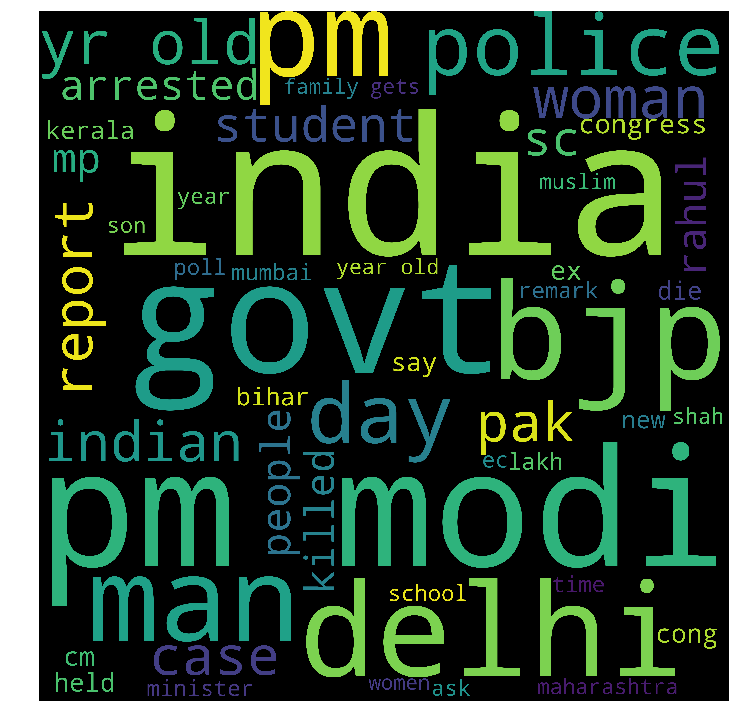

sports


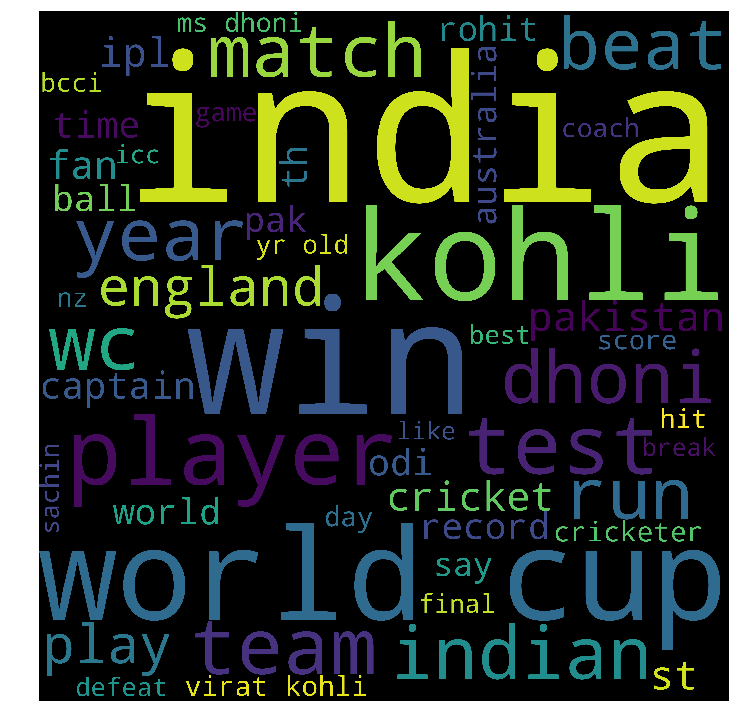

world


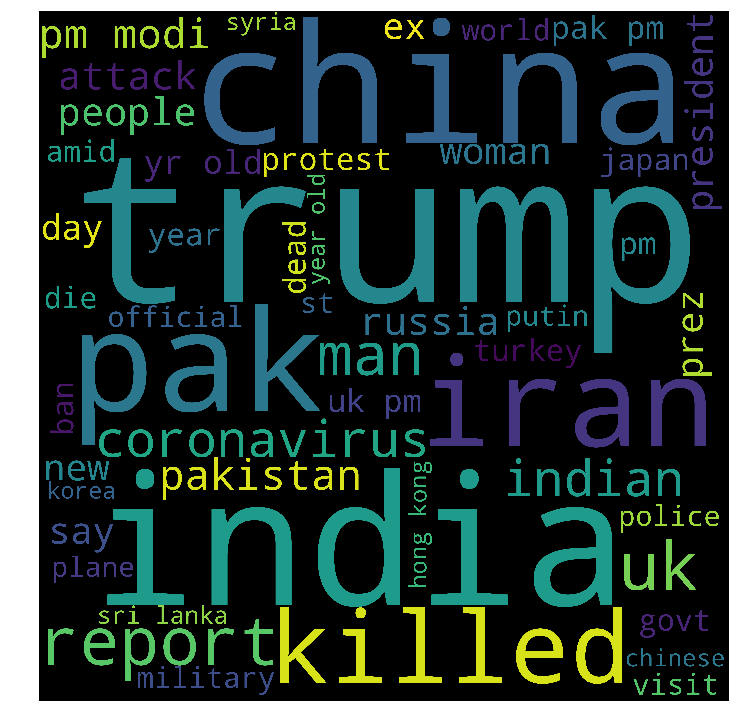

politics


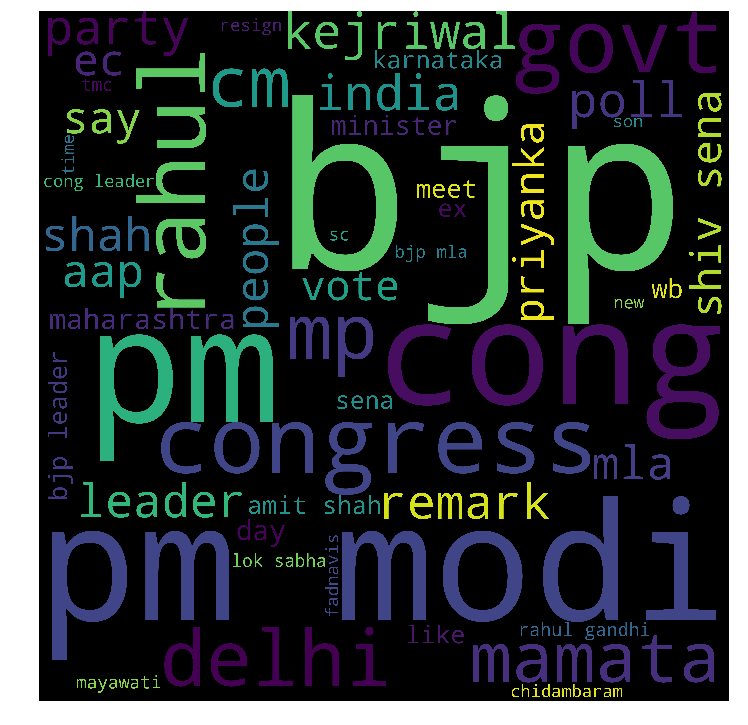

technology


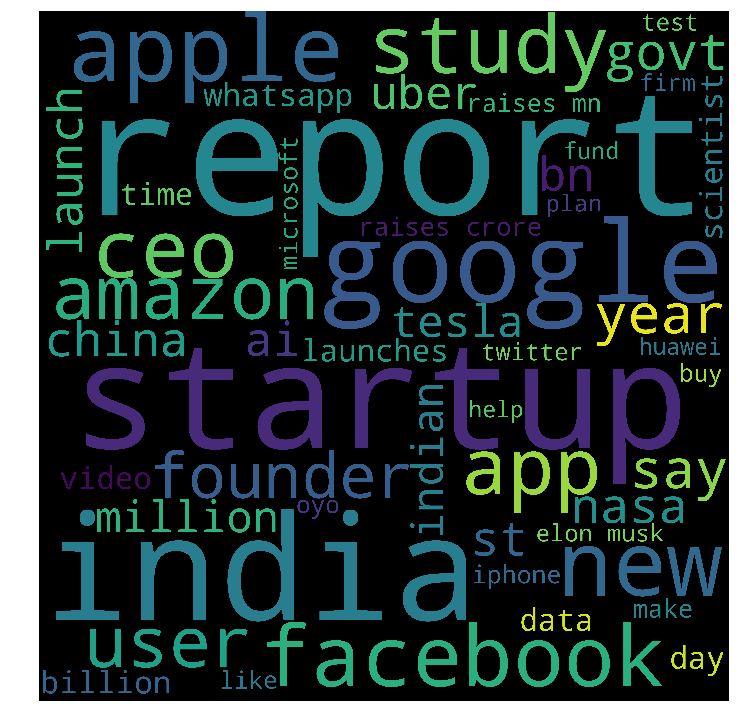

entertainment


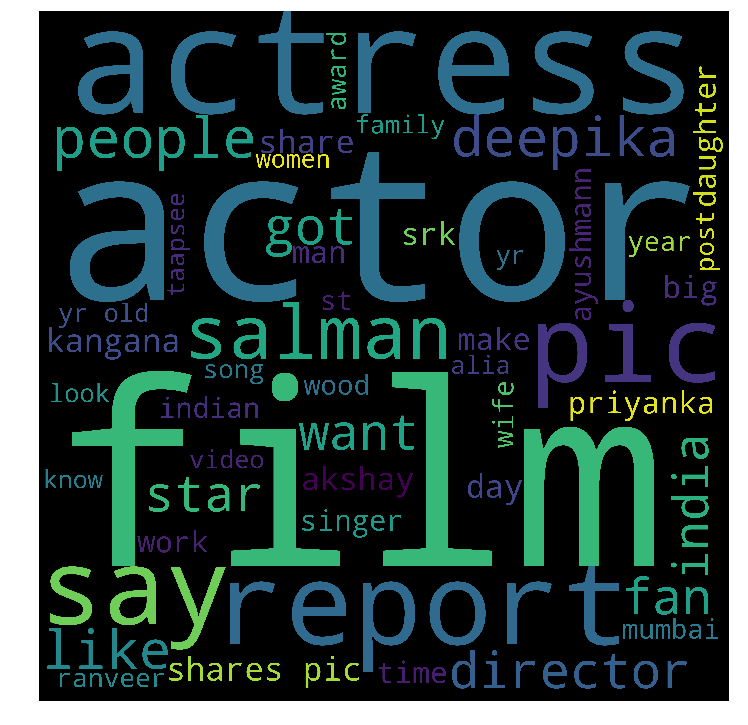

hatke


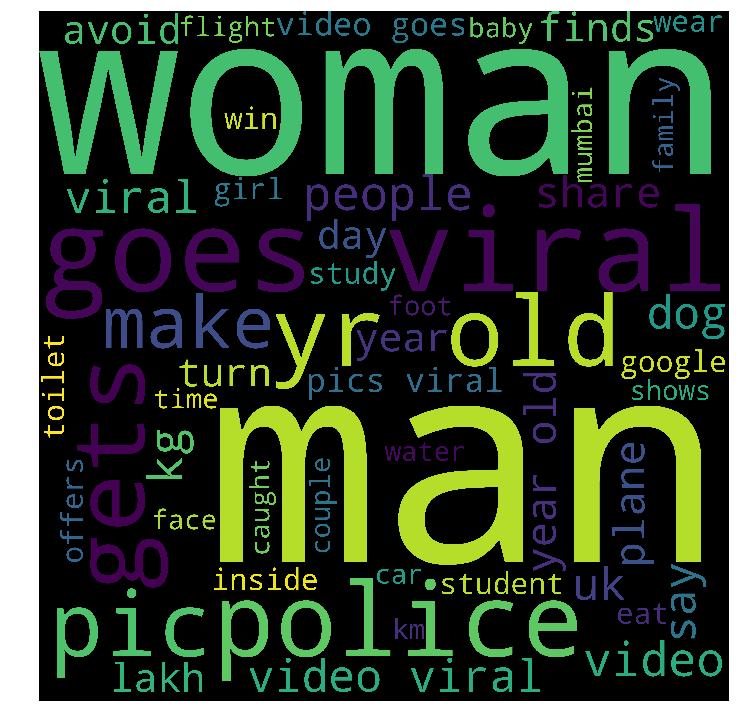

In [10]:
for x in []:
    buildWordCloud(x)

## Vectorizing

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data['news_c'])
X = vectorizer.transform(data['news_c'])

In [13]:
Y = data.drop(['news', 'news_c'], axis = 1)

In [14]:
print("X shape:", X.shape, "Y shape: ", Y.shape)

X shape: (34539, 23577) Y shape:  (34539, 7)


# Machine Learning

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [16]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.multiclass import OneVsRestClassifier

In [17]:
model_accuracies = pd.DataFrame()

## Logistic Regression

In [18]:
model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
scores = cross_val_score(model, X, Y, cv=10)
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
model_accuracies['LR'] = scores

Accuracy: 0.56 (+/- 0.03)


## Multinomial NB

In [19]:
model = OneVsRestClassifier(MultinomialNB())
scores = cross_val_score(model, X, Y, cv=10)
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
model_accuracies['MNB'] = scores

Accuracy: 0.53 (+/- 0.03)


## Bernoulli NB

In [20]:
model = OneVsRestClassifier(BernoulliNB())
scores = cross_val_score(model, X, Y, cv=10)
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
model_accuracies['BNB'] = scores

Accuracy: 0.65 (+/- 0.03)


## SGD - hinge

In [21]:
model = OneVsRestClassifier(SGDClassifier(loss='hinge', max_iter=1000, tol=0.001))
scores = cross_val_score(model, X, Y, cv=10)
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
model_accuracies['SGD-hinge'] = scores

Accuracy: 0.60 (+/- 0.02)


## SGD - log

In [22]:
model = OneVsRestClassifier(SGDClassifier(loss='log', max_iter=1000, tol=0.001))
scores = cross_val_score(model, X, Y, cv=10)
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
model_accuracies['SGD-log'] = scores

Accuracy: 0.42 (+/- 0.03)


## SGD - perceptron

In [23]:
model = OneVsRestClassifier(SGDClassifier(loss='perceptron', max_iter=1000, tol=0.001))
scores = cross_val_score(model, X, Y, cv=10)
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
model_accuracies['SGD-perceptron'] = scores

Accuracy: 0.61 (+/- 0.03)


## Comparison

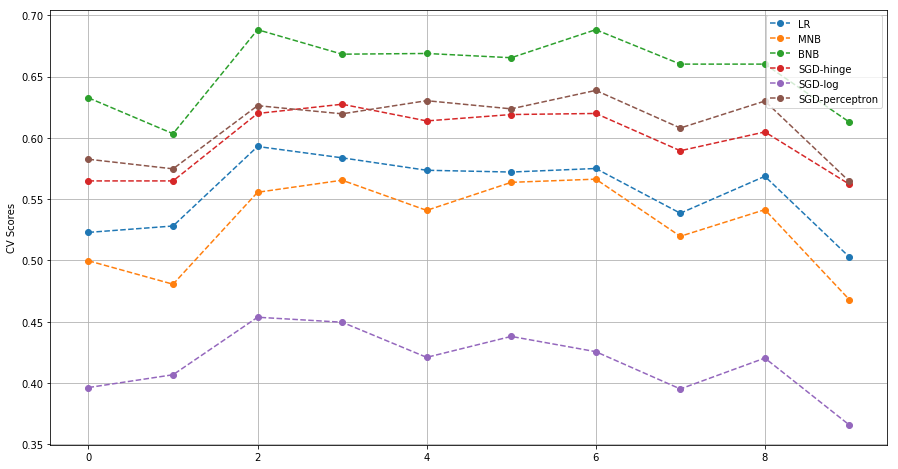

In [24]:
plt.figure(1, figsize=(15, 8))
for x in model_accuracies:
    plt.plot(model_accuracies[x], '--o',label=x)
plt.ylabel('CV Scores')    
plt.legend()
plt.grid()
plt.show()

## Model Training

In [25]:
models = {
    'lr': OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000)),
    'mnb': OneVsRestClassifier(MultinomialNB()),
    'bnb': OneVsRestClassifier(BernoulliNB()),
    'sgd-hinge': OneVsRestClassifier(SGDClassifier(loss='hinge', max_iter=1000, tol=0.001)),
    'sgd-log': OneVsRestClassifier(SGDClassifier(loss='log', max_iter=1000, tol=0.001)),
    'sgd-perceptron': OneVsRestClassifier(SGDClassifier(loss='perceptron', max_iter=1000, tol=0.001))
}

for model in tqdm(models.values()):
    model.fit(X, Y)

## Pickling

In [26]:
DIR = "E:/Models/News-Classification-Inshorts-Data/"
for k, v in tqdm(models.items()):
    pickle.dump(v, open(DIR+k+'.pkl', 'wb'))
pickle.dump(vectorizer, open(DIR+'vectorizer.pkl', 'wb'))    